In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt

from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np

In [2]:
cs_graph = Graph()
truth_graph = Graph()

In [3]:
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=True)
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
0 in the articles graph,
0 in the categories graph,
0 in the topics graph.


In [4]:
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True) 

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
50341 in the articles graph,
6524 in the categories graph,
208 in the topics graph.


In [5]:
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
57558 in the articles graph,
6925 in the categories graph,
208 in the topics graph.


In [6]:
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
119754 in the articles graph,
8590 in the categories graph,
210 in the topics graph.


In [7]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "degree", "out_degree", "in_degree", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles()]
    return df

In [8]:
df_articles_cs = vertices_to_df(cs_graph, level="articles")
df_categories_cs = vertices_to_df(cs_graph, level="categories")
df_topics_cs = vertices_to_df(cs_graph, level="topics")

In [280]:
df_topics_truth = vertices_to_df(truth_graph, level="topics")
df_topics_truth.head()

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,16923.0,9546.0,7377.0,604.39,681.86,526.93,14.0,545.0
People,28.0,14.0,14.0,20059.0,13245.0,6814.0,716.39,946.07,486.71,20.0,707.0
Countries,28.0,14.0,14.0,15316.0,5120.0,10196.0,547.00,365.71,728.29,1.0,229.0
Geography,28.0,14.0,14.0,41378.0,16348.0,25030.0,1477.79,1167.71,1787.86,21.0,1084.0
Business_Studies,28.0,14.0,14.0,3478.0,1802.0,1676.0,124.21,128.71,119.71,4.0,88.0


In [170]:
df_categories_cs.head()

,Topic,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
British_History_1500_and_before_including_Roman_Britain,History,102,46,56,585,322,263,5.74,7.00,4.70,73
Historical_figures,People,163,89,74,1056,676,380,6.48,7.60,5.14,108
Countries,Countries,219,101,118,5734,2401,3333,26.18,23.77,28.25,229
European_Countries,Geography,227,105,122,4393,1423,2970,19.35,13.55,24.34,56
Artists,People,77,49,28,305,214,91,3.96,4.37,3.25,38


In [171]:
#keep Topic and degree
df_categories_cs = df_categories_cs[["Topic", "degree"]]

In [172]:
#to csv
df_categories_cs.to_csv("data/categories_cs.csv", index=True)

In [173]:
df_articles_cs.head()

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
%C3%85land,Geography,European_Countries,4,3,1,7,3,4,1.75,1.00,4.00
%C3%89douard_Manet,People,Artists,9,6,3,13,6,7,1.44,1.00,2.33
%C3%89ire,Geography,European_Countries,5,3,2,16,5,11,3.20,1.67,5.50
%E2%82%AC2_commemorative_coins,Business_Studies,Currency,1,1,0,1,1,0,1.00,1.00,0.00
10th_century,History,General_history,52,21,31,246,125,121,4.73,5.95,3.90


In [174]:
#keep only Topic and degree
df_articles_cs = df_articles_cs[["Topic", "degree"]]
#sort by topic
df_articles_cs = df_articles_cs.sort_values(by="Topic")
df_articles_cs.head()

,Topic,degree
Fine_art,Art,19
Italian_Renaissance,Art,35
Drawing,Art,18
Neoclassicism,Art,30
Jewellery,Art,24


In [224]:
df_topics_cs.head(20)

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,7721.0,3827.0,3894.0,275.75,273.36,278.14,14.0,545.0
People,28.0,14.0,14.0,8677.0,5498.0,3179.0,309.89,392.71,227.07,20.0,707.0
Countries,28.0,14.0,14.0,5734.0,2401.0,3333.0,204.79,171.50,238.07,1.0,229.0
Geography,28.0,14.0,14.0,18546.0,7368.0,11178.0,662.36,526.29,798.43,21.0,1084.0
Business_Studies,28.0,14.0,14.0,1414.0,691.0,723.0,50.50,49.36,51.64,4.0,88.0
Science,28.0,14.0,14.0,9294.0,5364.0,3930.0,331.93,383.14,280.71,18.0,1122.0
Everyday_life,28.0,14.0,14.0,5328.0,3074.0,2254.0,190.29,219.57,161.00,12.0,374.0
Design_and_Technology,28.0,14.0,14.0,2323.0,1453.0,870.0,82.96,103.79,62.14,5.0,254.0
Music,28.0,14.0,14.0,914.0,607.0,307.0,32.64,43.36,21.93,4.0,140.0
IT,27.0,13.0,14.0,763.0,344.0,419.0,28.26,26.46,29.93,5.0,85.0


In [225]:
#keep only nb_articles 
df_topics_cs = df_topics_cs[["nb_articles"]]
#to csv
df_topics_cs.to_csv("data/topics_cs.csv", index=True)

In [175]:
#to csv
df_articles_cs.to_csv("data/articles_cs.csv")

In [176]:
df_articles_truth = vertices_to_df(truth_graph, level="articles")
df_articles_truth.head()

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,Historical_figures,11,11,0,11,11,0,1.0,1.0,0.0
%C3%85land,Geography,European_Countries,19,19,0,19,19,0,1.0,1.0,0.0
%C3%89douard_Manet,People,Artists,20,20,0,20,20,0,1.0,1.0,0.0
%C3%89ire,Geography,European_Countries,8,8,0,8,8,0,1.0,1.0,0.0
%C3%93engus_I_of_the_Picts,People,Historical_figures,10,10,0,10,10,0,1.0,1.0,0.0


In [177]:
#keep only index and Topic columns
df_articles_truth = df_articles_truth[["Topic", "degree"]]
df_articles_truth.head()

,Topic,degree
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,11
%C3%85land,Geography,19
%C3%89douard_Manet,People,20
%C3%89ire,Geography,8
%C3%93engus_I_of_the_Picts,People,10


In [178]:
#to csv
df_articles_truth.to_csv("data/articles_truth.csv")

In [81]:
dict_links = {}
prev_article = ""
with open('data/links.tsv') as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for j , line in enumerate(tsv_file):
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else : 
                    if line[0] != prev_article:
                        i= 1 
                        #print('new article : ', line[0])
       
                    topic1 = truth_graph.get_topic_of_article(line[0])
                    topic2 = truth_graph.get_topic_of_article(line[1])
                    if topic1 == None or topic2 == None:
                         dict_links[j] = [line[0],line[1],i]
                    else:
                        dict_links[j] = [line[0],line[1],i]
                    i += 1
                    prev_article = line[0]

In [180]:
#remove articles that are not in df_articles_cs
for key in list(dict_links.keys()):
    if dict_links[key][0] not in df_articles_cs.index or dict_links[key][1] not in df_articles_cs.index:
        del dict_links[key]
        

In [83]:
links_df = pd.DataFrame.from_dict(dict_links, orient='index', columns=['article_from', 'article_to', 'position'])

In [11]:
links_df.head()

,article_from,article_to,position
12,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,1
13,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,2
14,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,3
15,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,4
16,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,5


In [84]:
links_df['weight'] = links_df.apply(lambda row: cs_graph.get_weight_of_link(row['article_from'],row['article_to']),axis=1)
#links_df.sort_values(by=['weight'], ascending=False).head(20)
#map each article to its topic
links_df['topic_from'] = links_df.apply(lambda row: cs_graph.get_topic_of_article(row['article_from']),axis=1)
links_df['topic_to'] = links_df.apply(lambda row: cs_graph.get_topic_of_article(row['article_to']),axis=1)
#take weights != 0
links_df = links_df[links_df['weight'] != 0]

#delete links from the same topic
#links_df = links_df[links_df['topic_from'] != links_df['topic_to']]
# #size of group by topic_from and topic_to
#links_df['size'] = links_df.groupby(['topic_from', 'topic_to'])['topic_from'].transform('size')
#keep unique links
#links_df = links_df.drop_duplicates(subset=['topic_from', 'topic_to'], keep='first')
links_df.head(20)


,article_from,article_to,position,weight,topic_from,topic_to
24,%C3%85land,Baltic_Sea,2,1,Geography,Geography
32,%C3%85land,Nationality,10,1,Geography,Citizenship
35,%C3%85land,Russia,13,1,Geography,Geography
44,%C3%89douard_Manet,Claude_Monet,3,1,People,People
45,%C3%89douard_Manet,Diego_Vel%C3%A1zquez,4,1,People,People
46,%C3%89douard_Manet,Edgar_Allan_Poe,5,1,People,People
50,%C3%89douard_Manet,Impressionism,9,1,People,Art
52,%C3%89douard_Manet,Landscape,11,1,People,Geography
58,%C3%89douard_Manet,Renaissance,17,1,People,History
62,%C3%89ire,Canada,1,1,Geography,Geography


In [85]:
#create a new df with a column for each topic 
# that for each 1000 rows of links_df: put the number of appearance of each topic and store it in the corresponding column

#list of topics
topics = list(df_topics_cs.index)
#number of rows in links_df
nb_rows = links_df.shape[0]

#create a new df with a column for each topic
df_topics_links = pd.DataFrame(columns=topics)

#iterate over the rows of links_df
for i in range(0, nb_rows, 1000):
    #create a new df with a column for each topic
    df_topics_links_temp = pd.DataFrame(columns=topics)
    #for each topic
    for topic in topics:
        nb_appearance = 0
        #get the number of appearance of the topic in the 1000 rows
        nb_appearance += links_df[i:i+1000]['topic_to'].value_counts()[topic] if topic in links_df[i:i+1000]['topic_to'].value_counts() else 0
        #nb_appearance += links_df[i:i+1000]['topic_from'].value_counts()[topic] if topic in links_df[i:i+1000]['topic_from'].value_counts() else 0
        #add the number of appearance to the corresponding column
        df_topics_links_temp[topic] = [nb_appearance]
    #add the row to the df
    df_topics_links = df_topics_links.append(df_topics_links_temp)

df_topics_links.head()


C:\Users\youss\AppData\Local\Temp\ipykernel_12452\270858760.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topics_links = df_topics_links.append(df_topics_links_temp)
C:\Users\youss\AppData\Local\Temp\ipykernel_12452\270858760.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topics_links = df_topics_links.append(df_topics_links_temp)
C:\Users\youss\AppData\Local\Temp\ipykernel_12452\270858760.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topics_links = df_topics_links.append(df_topics_links_temp)
C:\Users\youss\AppData\Local\Temp\ipykernel_12452\270858760.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_

,History,People,Countries,Geography,Business_Studies,Science,Everyday_life,Design_and_Technology,Music,IT,Language_and_literature,Mathematics,Religion,Art,Citizenship
0,278,146,68,265,10,113,31,14,5,6,7,2,23,9,23
0,130,59,125,290,8,146,36,19,13,11,48,5,38,9,63
0,105,88,57,266,9,213,51,29,7,15,58,21,41,4,36
0,106,92,54,276,10,184,55,24,21,1,49,6,50,8,64
0,66,55,80,327,11,203,45,13,9,7,46,18,53,17,50


In [86]:
#sum the values of all previous rows for each topic
df_topics_links = df_topics_links.cumsum(axis=0)
df_topics_links.head()


,History,People,Countries,Geography,Business_Studies,Science,Everyday_life,Design_and_Technology,Music,IT,Language_and_literature,Mathematics,Religion,Art,Citizenship
0,278,146,68,265,10,113,31,14,5,6,7,2,23,9,23
0,408,205,193,555,18,259,67,33,18,17,55,7,61,18,86
0,513,293,250,821,27,472,118,62,25,32,113,28,102,22,122
0,619,385,304,1097,37,656,173,86,46,33,162,34,152,30,186
0,685,440,384,1424,48,859,218,99,55,40,208,52,205,47,236


In [87]:
#invert columns and rows
df_topics_links = df_topics_links.transpose()
#Set the columns names to the number of rows
df_topics_links.columns = range(1000, nb_rows+1000, 1000)
#rename last column to 57461
df_topics_links = df_topics_links.rename(columns={58000: 57461})	 
#add two empty columns in the beginning


df_topics_links.head()


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,...,49000,50000,51000,52000,53000,54000,55000,56000,57000,57461
History,278,408,513,619,685,777,899,976,1058,1155,...,4562,4630,4710,4782,4873,4947,5025,5136,5242,5276
People,146,205,293,385,440,495,549,605,656,742,...,3691,3734,3822,3905,3959,4041,4132,4207,4312,4329
Countries,68,193,250,304,384,459,526,575,665,740,...,3330,3420,3496,3557,3635,3753,3815,3850,3927,3970
Geography,265,555,821,1097,1424,1771,2095,2353,2651,2984,...,15076,15370,15673,15940,16317,16668,16924,17283,17618,17770
Business_Studies,10,18,27,37,48,57,72,94,108,127,...,763,789,807,819,830,854,874,887,896,899


In [88]:
#to_csv
df_topics_links.to_csv("data/topics_links_race.csv", index=True)

In [319]:
#keep only topic_from, topic_to and size
links_df = links_df[["topic_from", "topic_to", "size"]]
#to csv
links_df.to_csv("data/links_truth.csv", index=False)

In [240]:
#filter weight = 0 (unexplored links in the article)
links_df['nb_links'] = links_df.groupby('article_from')['article_from'].transform('count')
#links_df = links_df[links_df['weight'] != 0]

In [298]:
#get the Topic of the article_from and article_to from df_articles_cs
links_df['topic_from'] = links_df.apply(lambda row: df_articles_cs.loc[row['article_from']]['Topic'],axis=1)
links_df['topic_to'] = links_df.apply(lambda row: df_articles_cs.loc[row['article_to']]['Topic'],axis=1)
#drop links between articles of the same category
links_df = links_df[links_df['topic_from'] != links_df['topic_to']]
links_df.head(20)

KeyError: '%C3%81ed%C3%A1n_mac_Gabr%C3%A1in'

In [235]:
#keep only ctegory_from, ctegory_to and ones (in this order)
links_df = links_df[['topic_from', 'topic_to', 'weight']]
links_df.head(20)



KeyError: "['topic_from', 'topic_to'] not in index"

In [242]:
#group same links and sum the weight
links_df = links_df.groupby(['topic_from', 'topic_to']).sum().reset_index()
#keep only topic_from, topic_to and weight
links_df = links_df[['topic_from', 'topic_to', 'weight']]

KeyError: 'topic_from'

In [222]:
#to csv
links_df.to_csv("data/topics_links_cs.csv", index=False)

In [128]:
links_df['nb_explored_links'] = links_df.groupby('article_from')['article_from'].transform('count')
links_df['proportion_explored'] = links_df['nb_explored_links']/links_df['nb_links']
#drop duplicates
links_df.sample(20)


,article_from,article_to,position,weight,nb_links,nb_explored_links,proportion_explored
30081,Democratic_Republic_of_the_Congo,Chad,29,1,113,36,0.318584
53080,Hurricane_Andrew,Tropical_cyclone,21,6,18,14,0.777778
103197,Suez_Canal,Canal,7,10,21,15,0.714286
66886,Logic,Plato,21,3,18,15,0.833333
37535,European_Parliament,United_Kingdom,34,6,32,11,0.343750
16373,Bob_Dylan,England,14,1,35,24,0.685714
35930,England,Richard_I_of_England,125,20,127,121,0.952756
114344,Vincent_van_Gogh,Netherlands,18,5,22,16,0.727273
86010,Planet,Venus,44,39,35,29,0.828571
7551,Antarctica,Argentina,9,1,52,38,0.730769


In [129]:
links_df['ones'] = 1
#keep article_from, article_to 
links_df = links_df[["article_from", "article_to", "ones"]]
print(len(links_df))

links_df.head()


33254


,article_from,article_to,ones
127,10th_century,11th_century,1
128,10th_century,9th_century,1
129,10th_century,Algeria,1
130,10th_century,Beer,1
132,10th_century,Byzantine_Empire,1


In [130]:
#to csv
links_df.to_csv("data/links_cs.csv", index=False)

In [ ]:
#drop all columns except article_from and article_to and weight
#links_df = links_df[['article_from', 'article_to']]


,article_from,article_to,ones
12,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,1
13,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,1
14,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,1
15,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,1
16,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,1


In [ ]:
#build a csv file with the links and their weight
links_df.to_csv('data/links_weight.csv', index=False)

C:\Users\youss\AppData\Local\Temp\ipykernel_11904\645204640.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(links_df['nb_links'], bins=100, kde=True, rug=False)


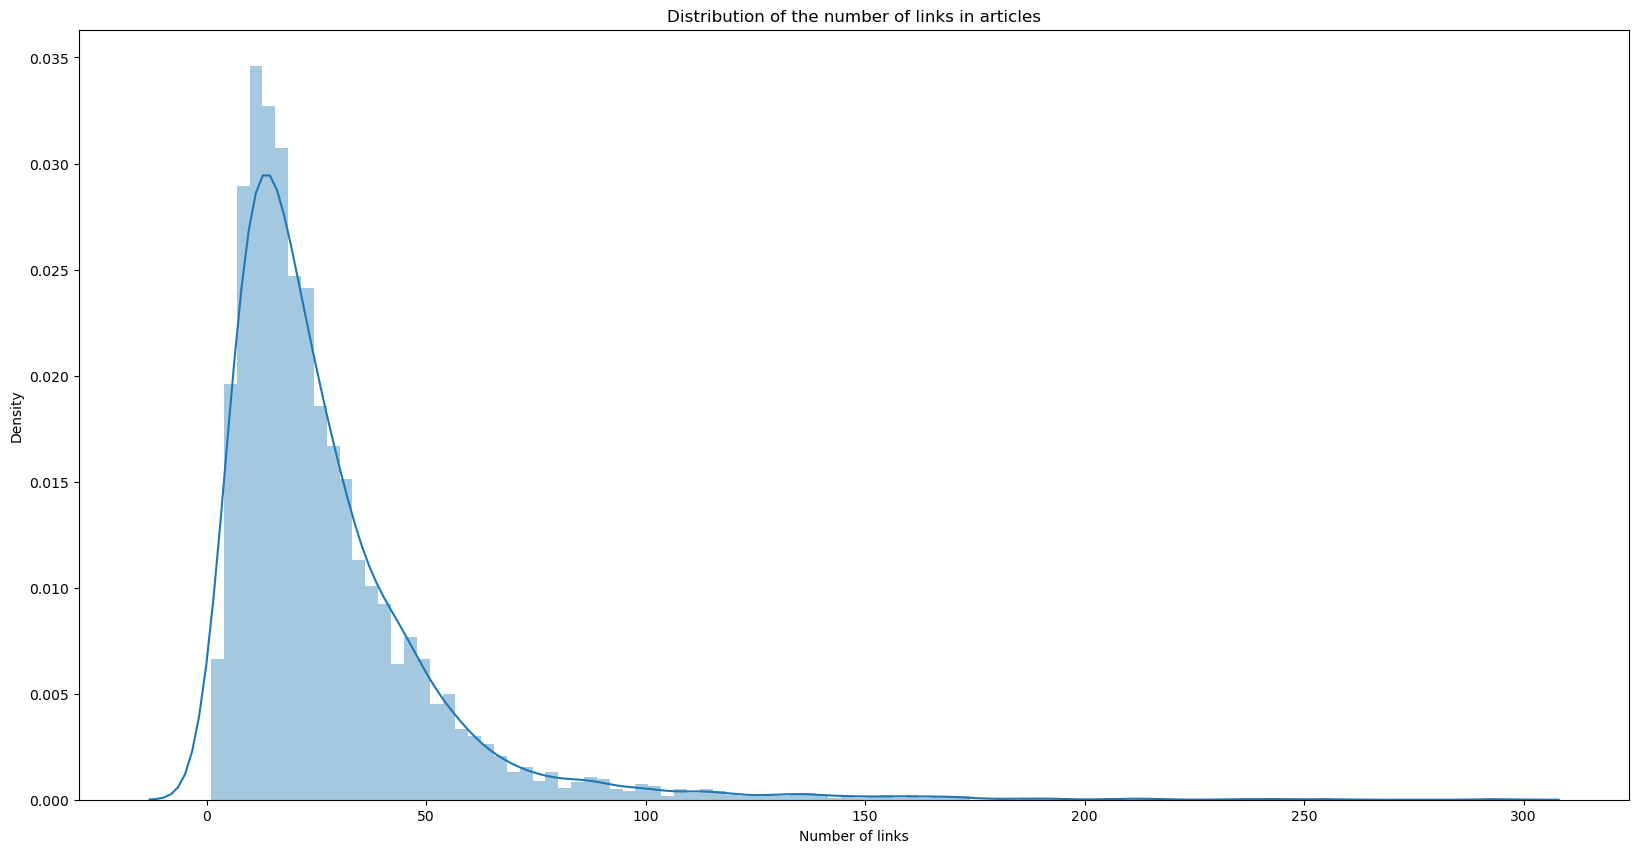

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(links_df['nb_links'], bins=100, kde=True, rug=False)
plt.title("Distribution of the number of links in articles")
plt.xlabel("Number of links")
plt.ylabel("Density")
plt.show()

Observation: The number of links distribution in articles is skewed to the right. The majority of articles have less than 100 links.
A possible approach to solve this is to divide the articles into multiple groups.

In [ ]:
#plot the avegrage of nb_explored_links and proportion_explored for each nb_links
# links_df['nb_links'] = links_df['nb_links'].astype(int)
# links_df['nb_explored_links'] = links_df['nb_explored_links'].astype(int)
# links_df['proportion_explored'] = links_df['proportion_explored'].astype(float)
# links_df = links_df.groupby('nb_links').mean()
# links_df = links_df.reset_index()
#filter nb_links > 75
links_df = links_df[links_df['nb_links'] <= 100]
# links_df

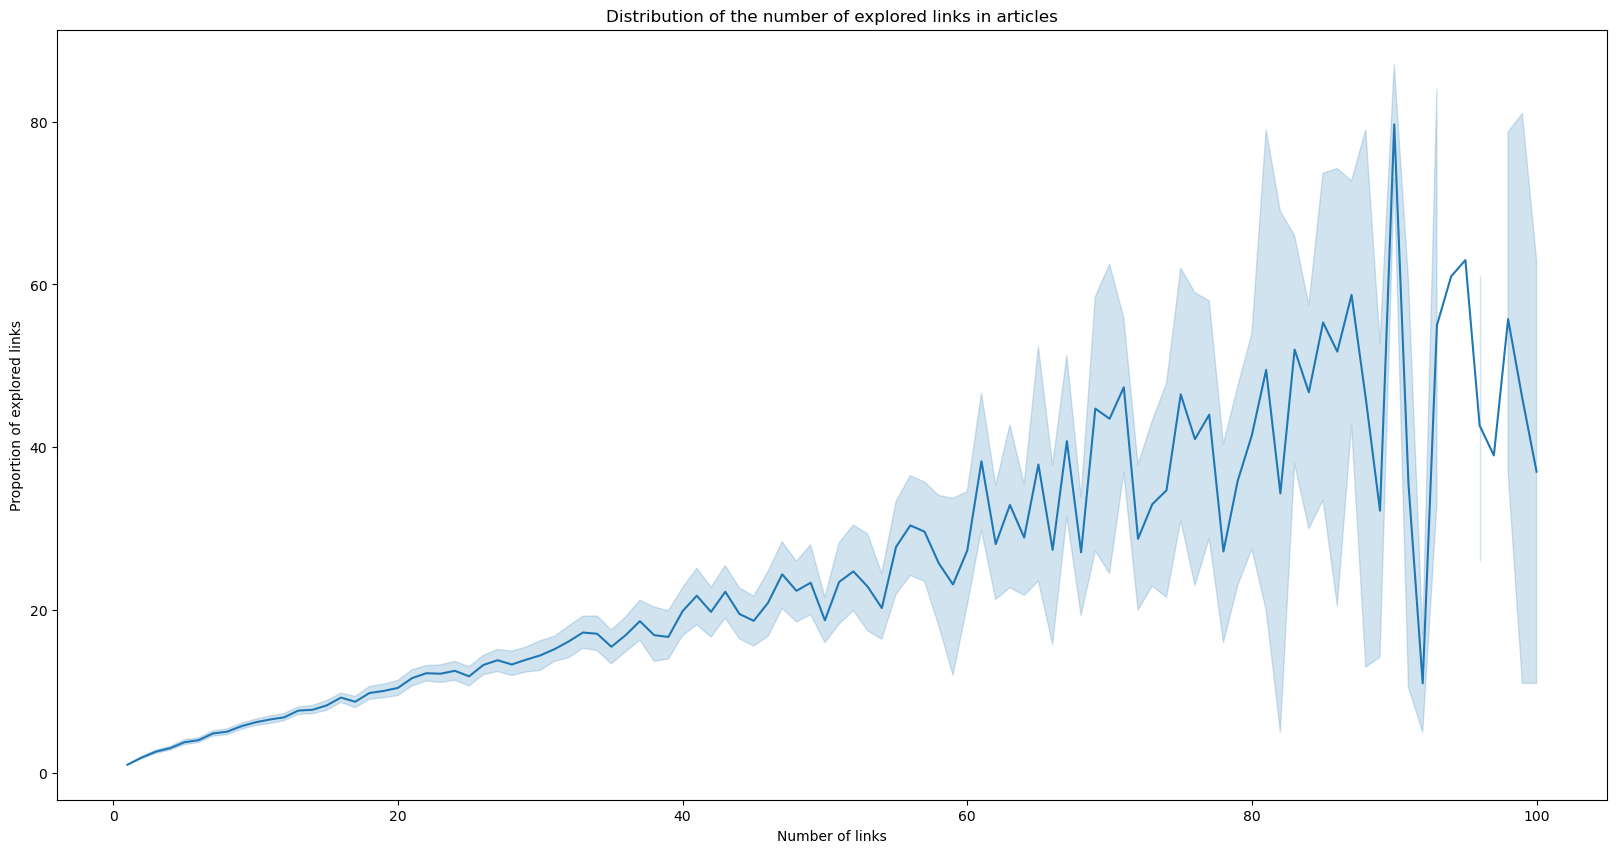

In [ ]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links")
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

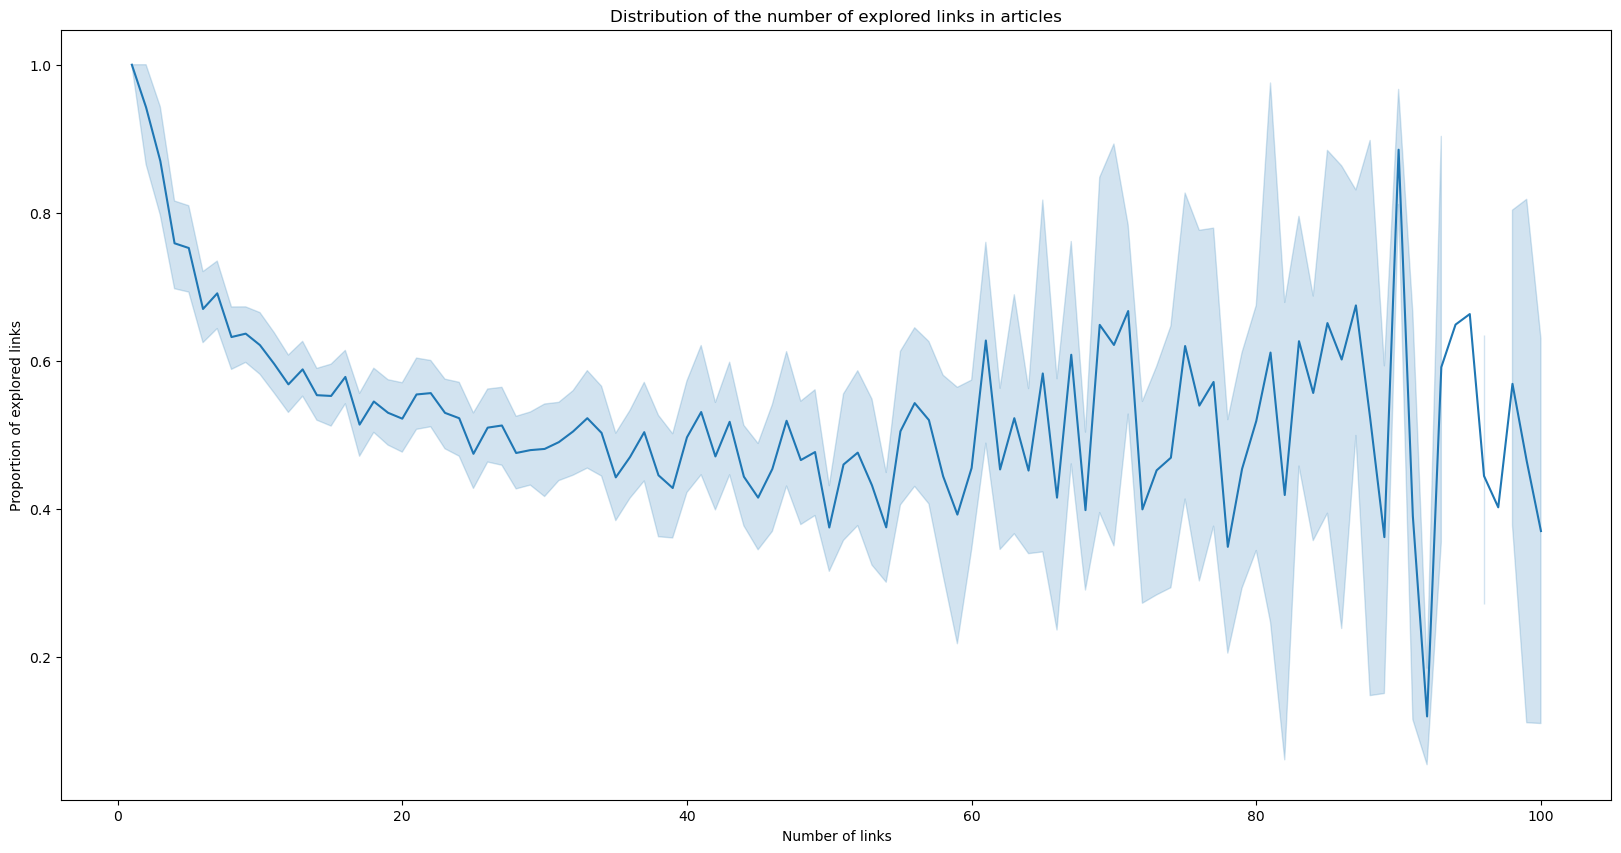

In [ ]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored")
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()



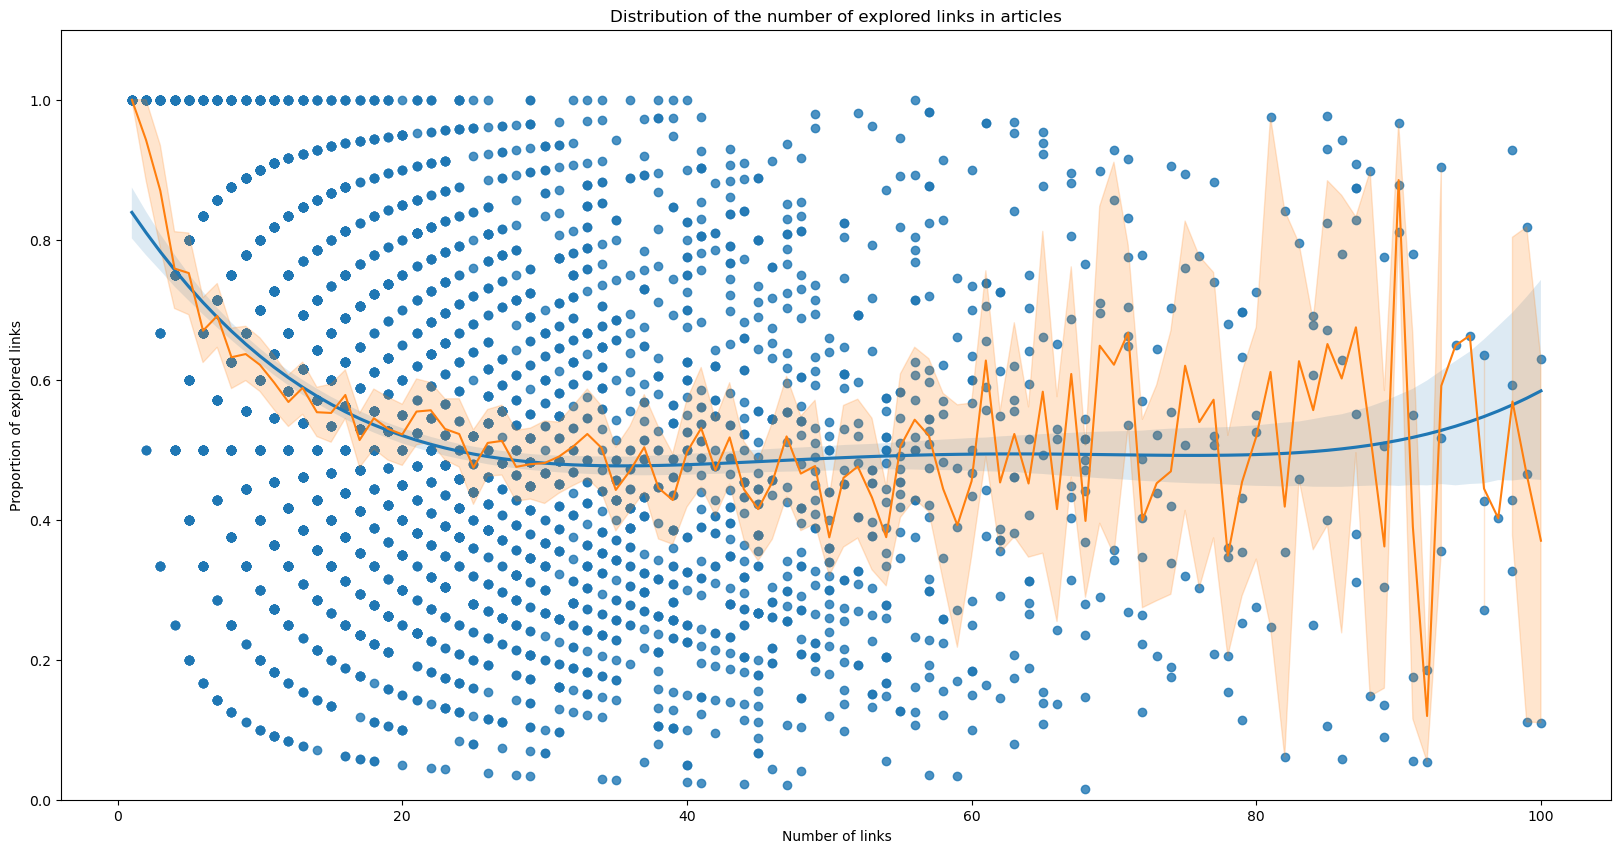

In [ ]:
#plot the distribution of the nb_explored_links by nb_links with a linear regression
plt.figure(figsize=(20,10))
#scale the y axis to 0-1
plt.ylim(0,1.1)

sns.regplot(data=links_df, x="nb_links", y="proportion_explored", order = 4, scatter=True)
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored", errorbar=('ci',95))
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


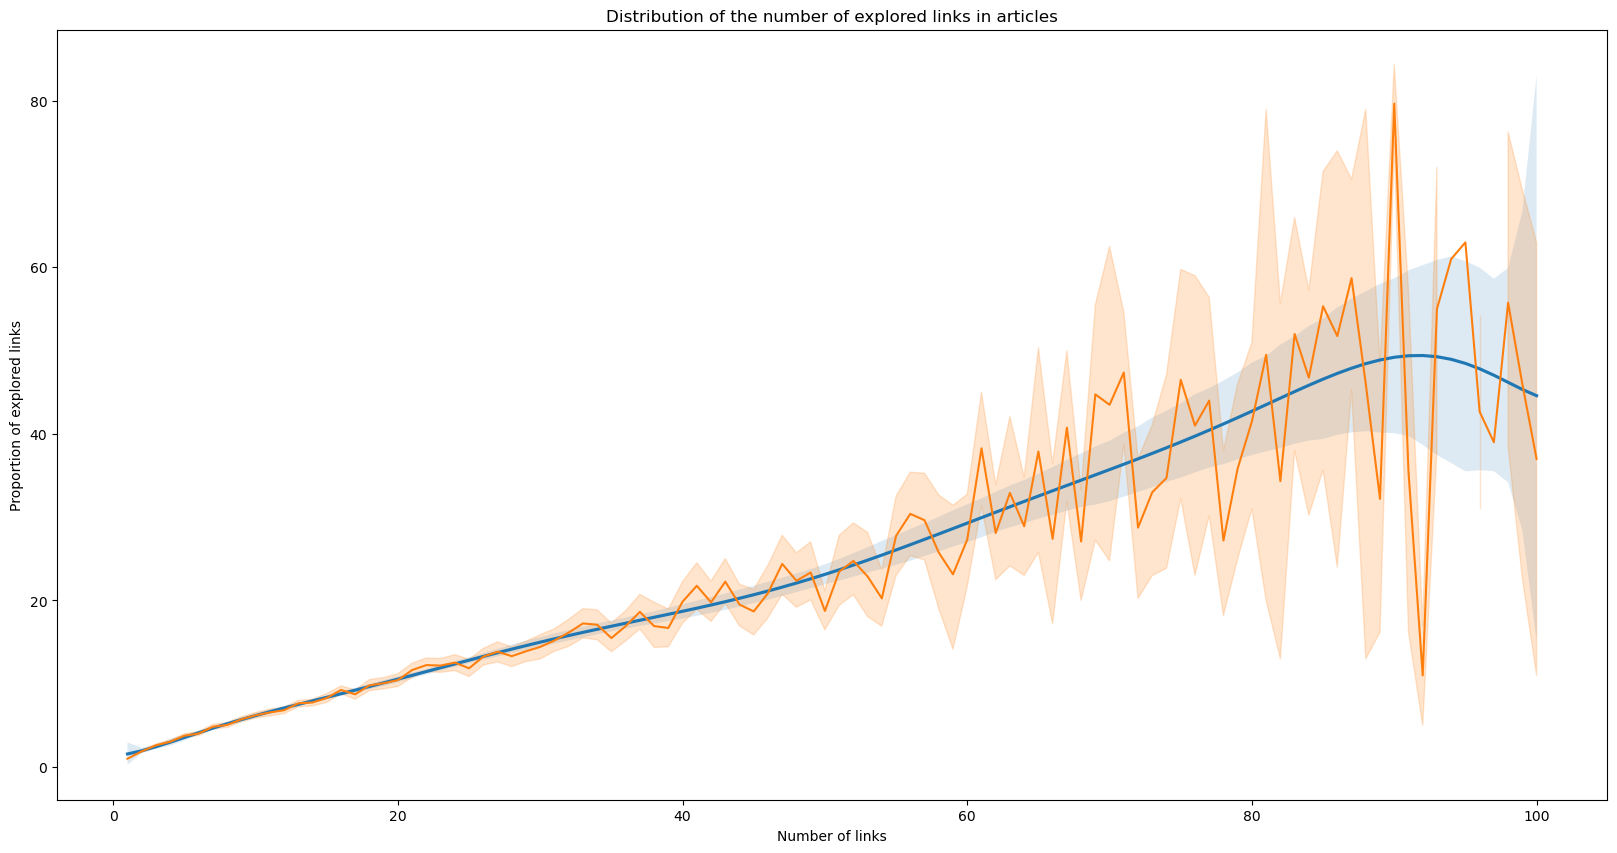

In [ ]:
plt.figure(figsize=(20,10))
sns.regplot(data=links_df, x="nb_links", y="nb_explored_links", order = 10, scatter=False)
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links", errorbar=('ci',90))
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


In [ ]:
#devide links_df into 2 groups : nb_links < 80 and nb_links > 80
links_df_1 = links_df[links_df['nb_links'] < 60]
links_df_2 = links_df[links_df['nb_links'] >= 60]

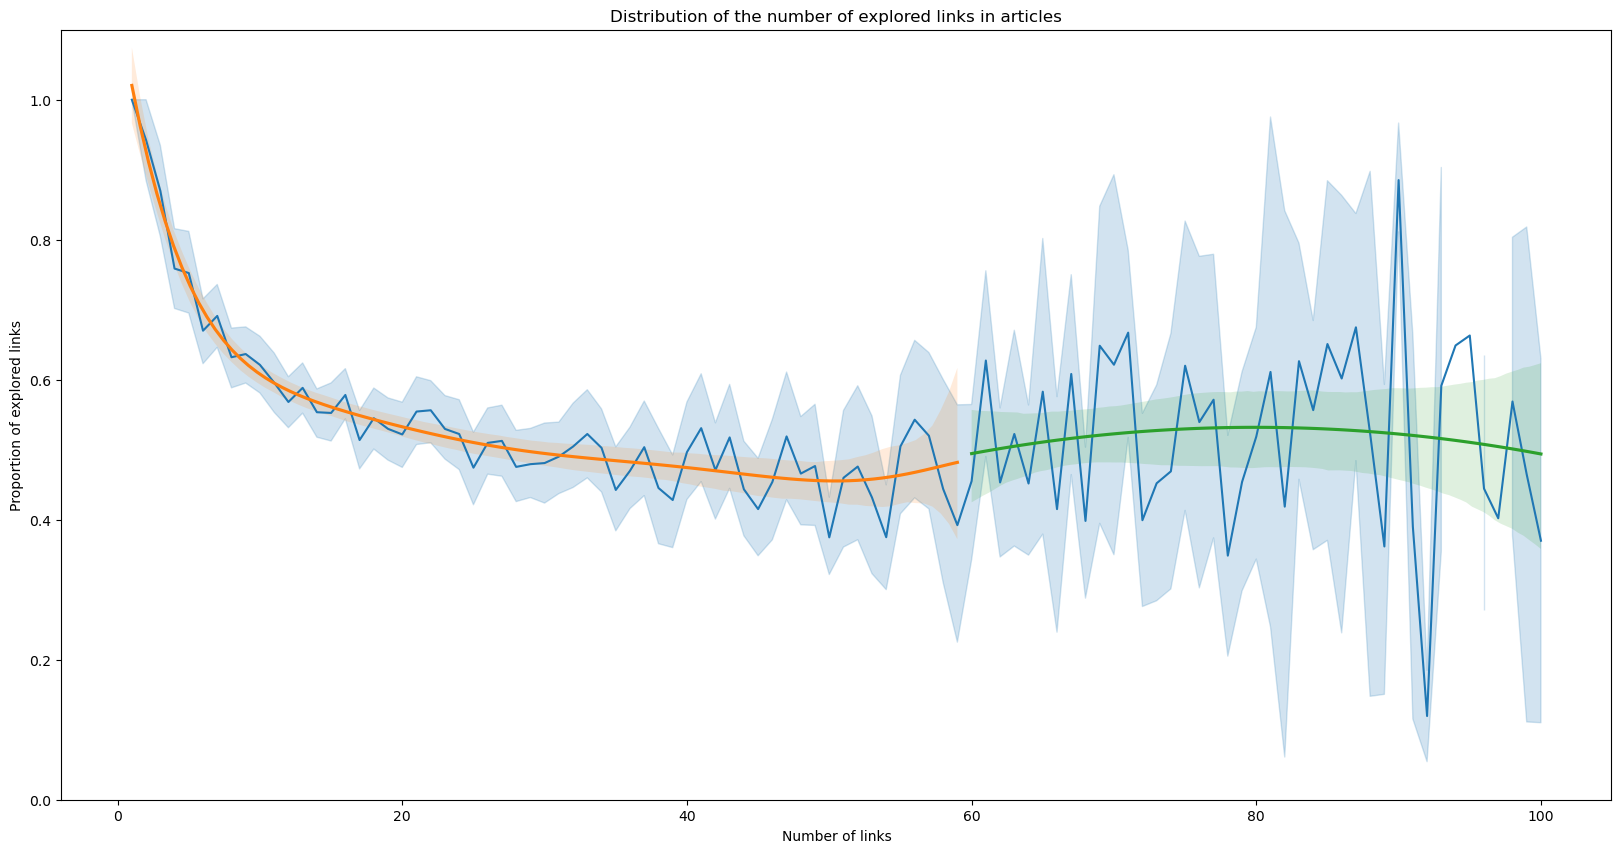

In [ ]:
#plot the the nb_explored_links by nb_links for the 2 dfs in the same plot
plt.figure(figsize=(20,10))
#scale the y axis to 0-1
plt.ylim(0,1.1)
sns.lineplot(data=links_df, x="nb_links", y="proportion_explored")
sns.regplot(data=links_df_1, x="nb_links", y="proportion_explored", order = 7, scatter=False)
sns.regplot(data=links_df_2, x="nb_links", y="proportion_explored", order = 2, scatter=False)
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()


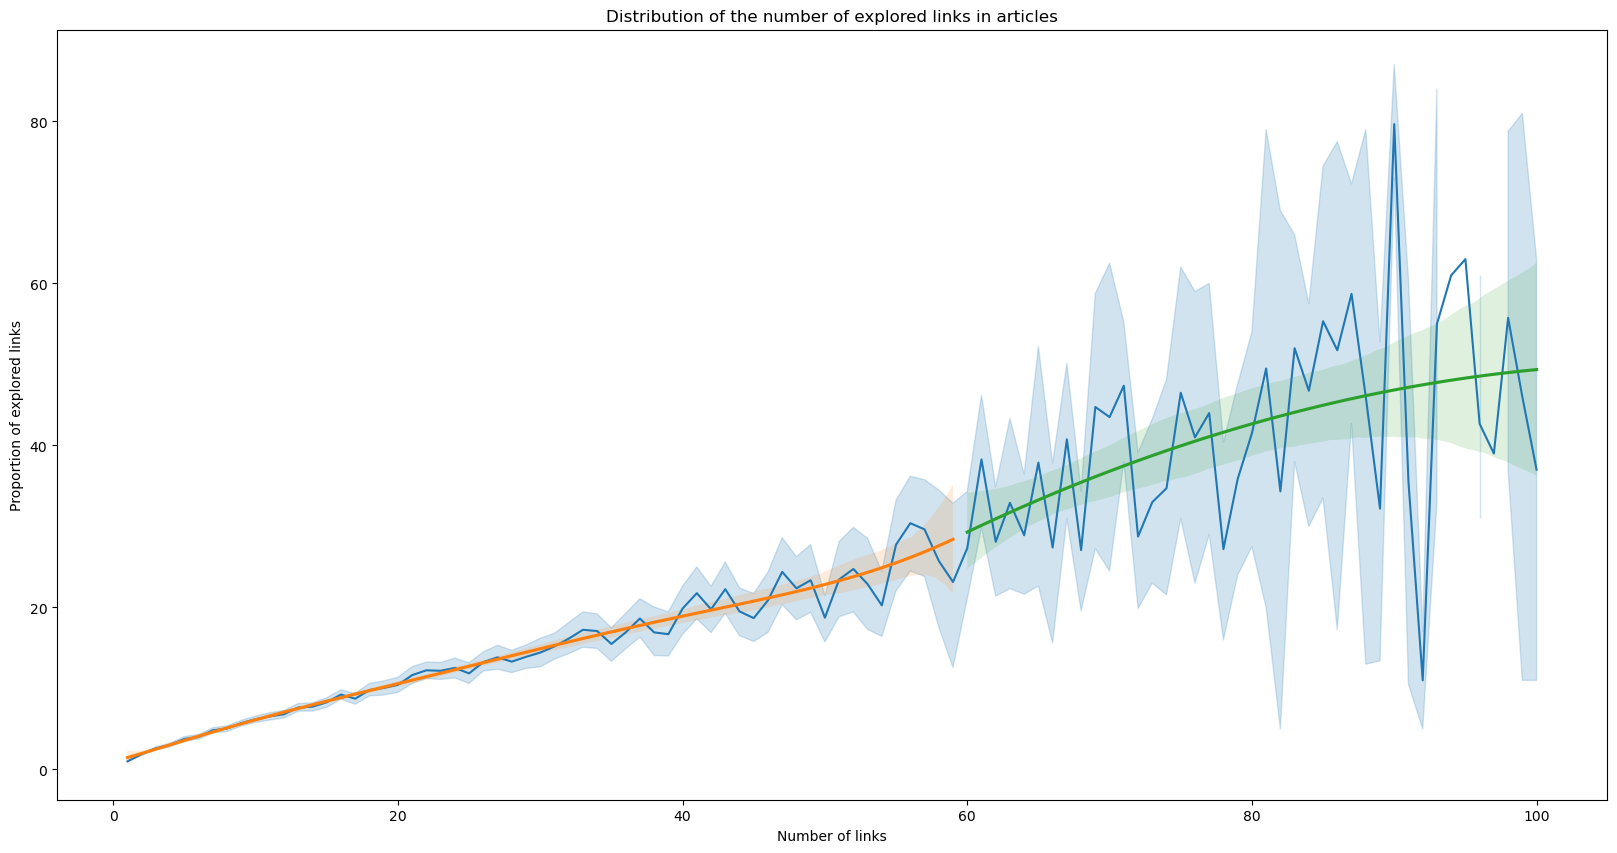

In [ ]:

plt.figure(figsize=(20,10))
#scale the y axis to 0-1
sns.lineplot(data=links_df, x="nb_links", y="nb_explored_links")
sns.regplot(data=links_df_1, x="nb_links", y="nb_explored_links", order = 7, scatter=False)
sns.regplot(data=links_df_2, x="nb_links", y="nb_explored_links", order = 2, scatter=False)
plt.title("Distribution of the number of explored links in articles")
plt.xlabel("Number of links")
plt.ylabel("Proportion of explored links")
plt.show()

In [ ]:
links_df['nb_links'] = links_df['nb_links'].astype(int)
links_df['nb_explored_links'] = links_df['nb_explored_links'].astype(int)
links_df['proportion_explored'] = links_df['proportion_explored'].astype(float)
links_df = links_df.groupby('nb_links').mean()
links_df = links_df.reset_index()

In [ ]:
#print the min nb_links from which the proportion of explored links is < 0.5
print(links_df[links_df['proportion_explored'] < 0.5]['nb_links'].min())

25


In [ ]:
dfs = []
for i in range(0,75,25):
    dfs.append(links_df[(links_df['nb_links'] >= i) & (links_df['nb_links'] < i+25)])

In [ ]:
df = pd.DataFrame(columns=['nb_links', 'nb_explored_links', 'proportion_explored'])

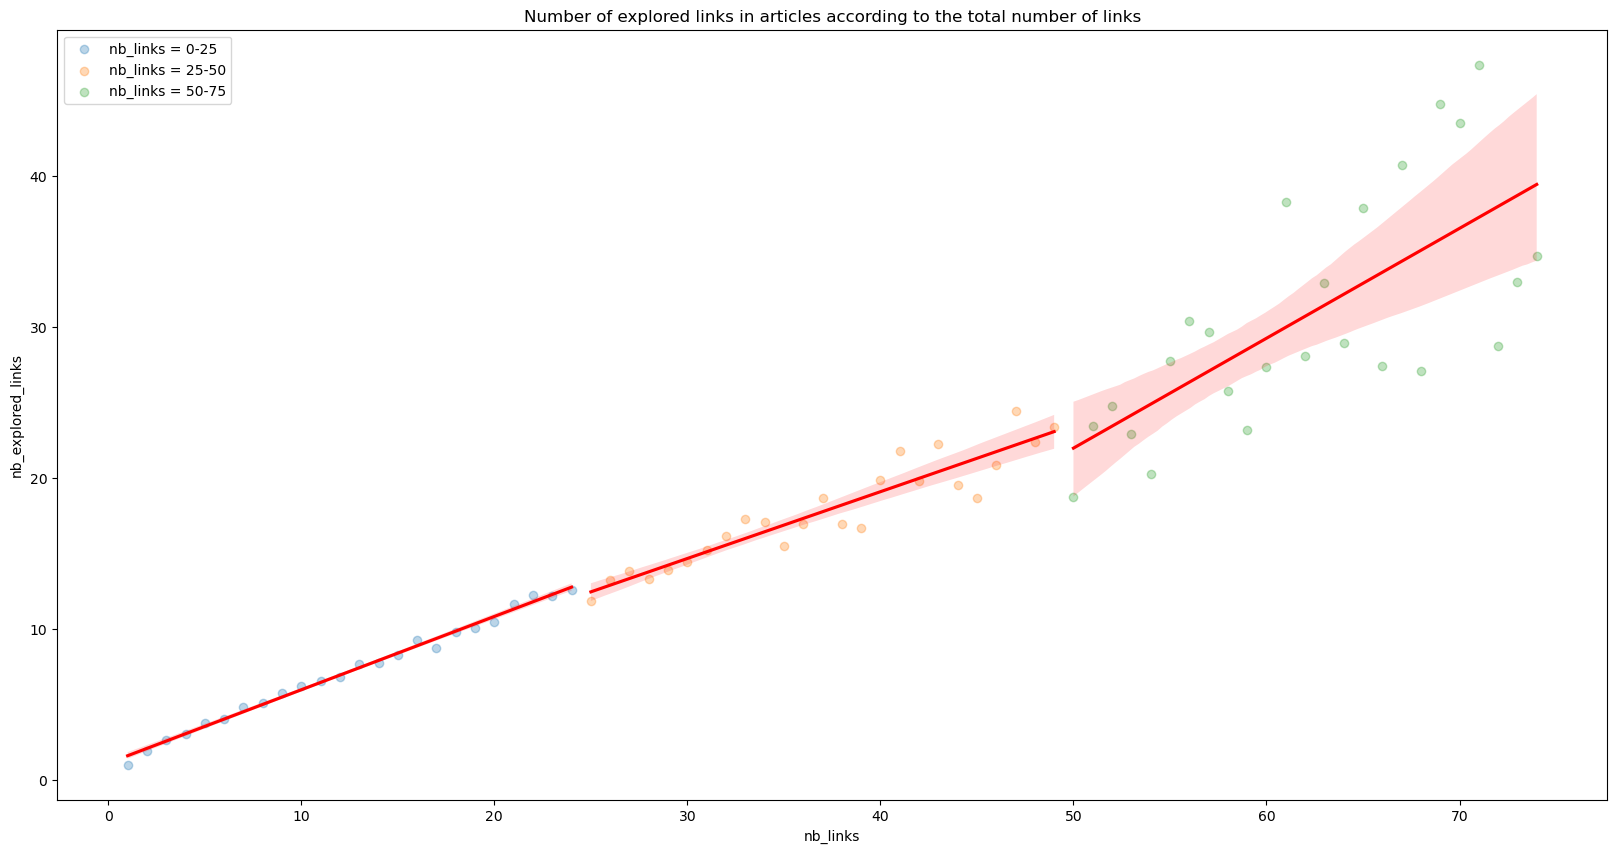

In [ ]:
#plot the distribution of the nb_explored_links for each nb_links df in the same plot
#make plot more readable
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Number of explored links in articles according to the total number of links")
ax.set_xlabel("Number of links")
ax.set_ylabel("Number of explored links")

for i, df in enumerate(dfs):
    sns.regplot(x="nb_links", y="nb_explored_links", data=df, ax=ax, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.3}, label="nb_links = "+str(i*25)+"-"+str((i+1)*25))

ax.legend()
plt.show()

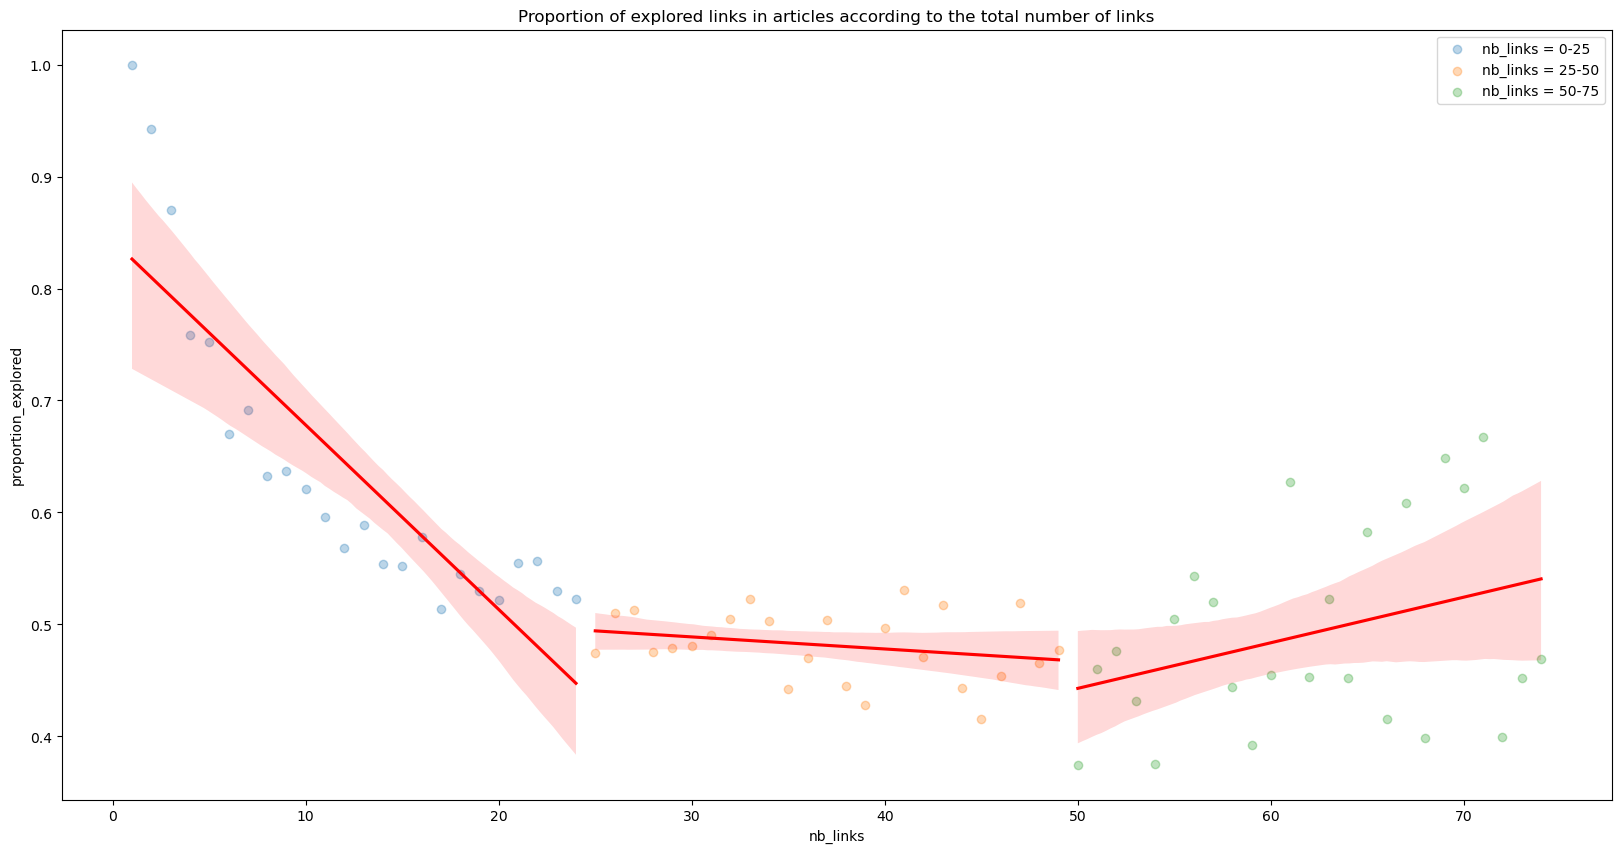

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Proportion of explored links in articles according to the total number of links")
ax.set_xlabel("Number of links")
ax.set_ylabel("Proportion of explored links")

for i, df in enumerate(dfs):
    sns.regplot(x="nb_links", y="proportion_explored", data=df, ax=ax, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.3}, label="nb_links = "+str(i*25)+"-"+str((i+1)*25))

ax.legend()
plt.show()

My theory:
The proportion of explored links in an article is decresing as the total nb of links increases until a certain point (40links) from which the proportion of explored links become constant.
This is explianed by the fact that readers tend to loose interest in articles with a number of articles that exceeds X links.


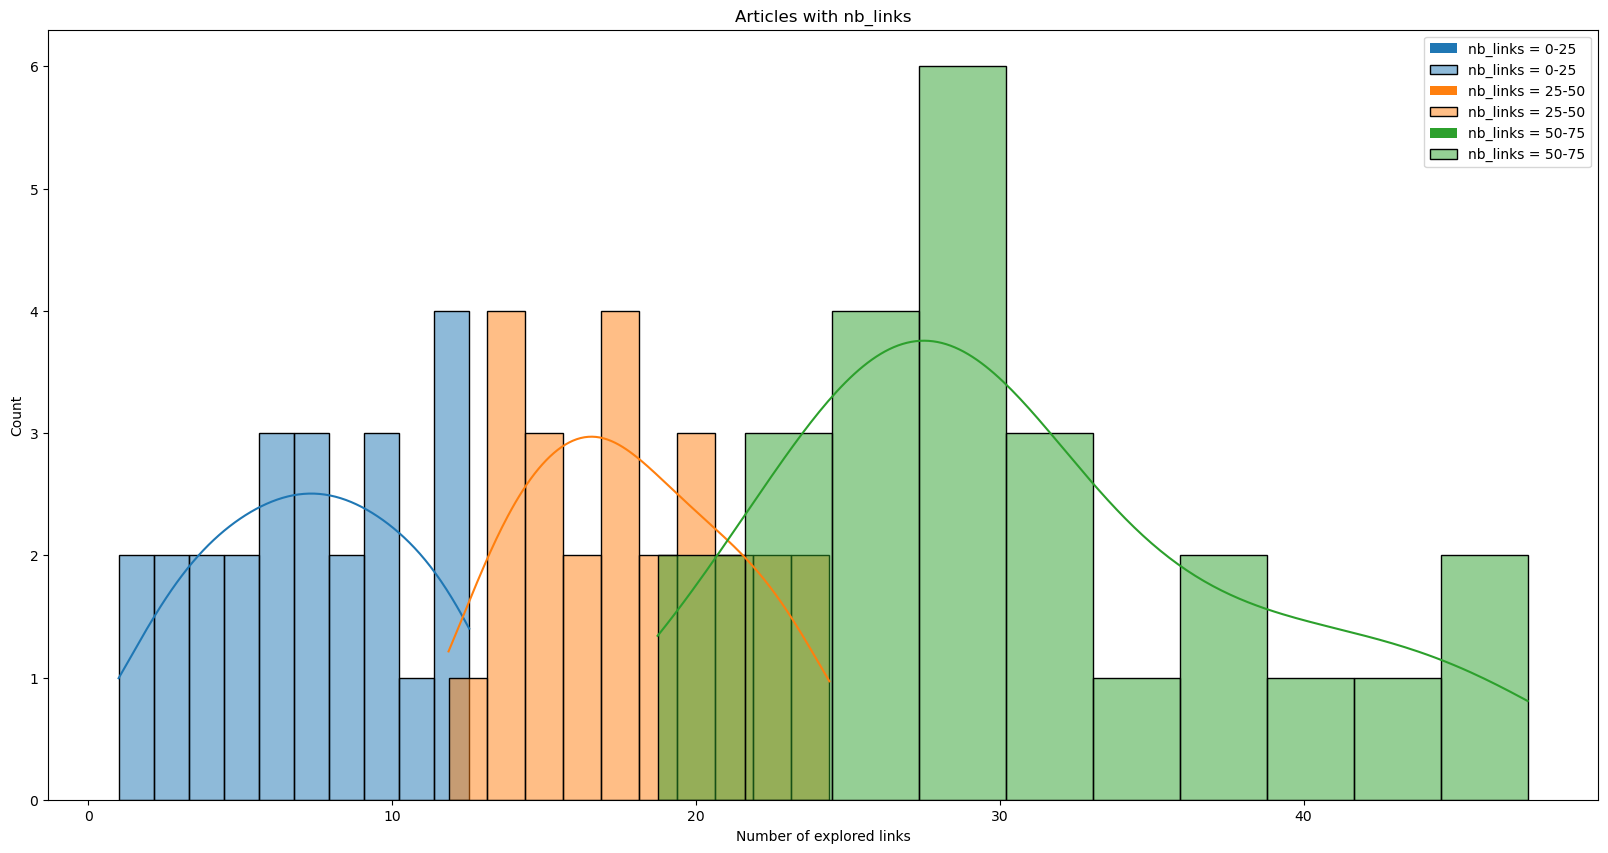

In [ ]:
#plot the distribution of the nb_explored_links for each nb_links df in the same plot
fig, ax = plt.subplots(figsize=(20,10))

for i, df in enumerate(dfs):
    sns.histplot(x="nb_explored_links", data=df, ax=ax, kde=True, bins= 10, stat='count', label="nb_links = "+str(i*25)+"-"+str((i+1)*25))
    

ax.set_title("Articles with nb_links")
ax.set_xlabel("Number of explored links")
ax.set_ylabel("Count")
plt.legend()



plt.show()


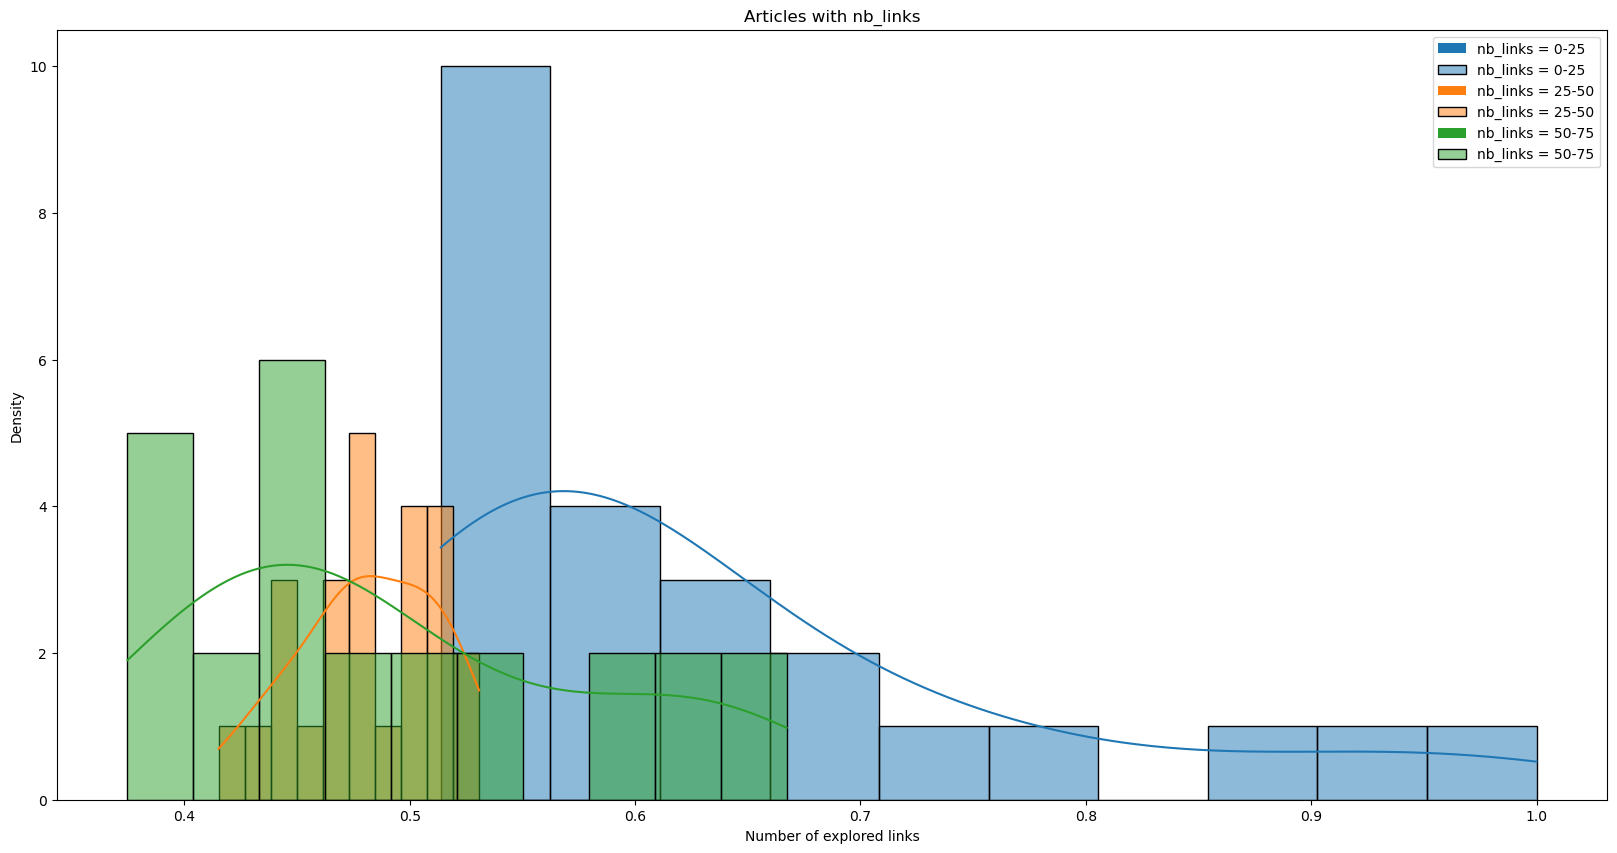

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

for i, df in enumerate(dfs):
    sns.histplot(x="proportion_explored", data=df, ax=ax, kde=True, bins= 10, stat='count', label="nb_links = "+str(i*25)+"-"+str((i+1)*25),
               )
    

ax.set_title("Articles with nb_links")
ax.set_xlabel("Number of explored links")
ax.set_ylabel("Density")
plt.legend()



plt.show()



# Dijkstra

In [ ]:
truth_adj = truth_graph.matrix_articles
truth_adj



{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': {'Bede': 1,
  'Columba': 1,
  'D%C3%A1l_Riata': 1,
  'Great_Britain': 1,
  'Ireland': 1,
  'Isle_of_Man': 1,
  'Monarchy': 1,
  'Orkney': 1,
  'Picts': 1,
  'Scotland': 1,
  'Wales': 1},
 '%C3%85land': {'20th_century': 1,
  'Baltic_Sea': 1,
  'Crimean_War': 1,
  'Currency': 1,
  'Euro': 1,
  'European_Union': 1,
  'Finland': 1,
  'League_of_Nations': 1,
  'List_of_countries_by_system_of_government': 1,
  'Nationality': 1,
  'Parliamentary_system': 1,
  'Police': 1,
  'Russia': 1,
  'Stockholm': 1,
  'Sweden': 1,
  'Time_zone': 1,
  'Tourism': 1,
  'United_Kingdom': 1,
  'World_War_II': 1},
 '%C3%89douard_Manet': {'Absinthe': 1,
  'Beer': 1,
  'Claude_Monet': 1,
  'Diego_Vel%C3%A1zquez': 1,
  'Edgar_Allan_Poe': 1,
  'France': 1,
  'Francisco_Goya': 1,
  'Germany': 1,
  'Impressionism': 1,
  'Italy': 1,
  'Landscape': 1,
  'Netherlands': 1,
  'Painting': 1,
  'Paris': 1,
  'Photography': 1,
  'Raphael': 1,
  'Renaissance': 1,
  'Sweden': 1,
  'United_

In [ ]:
truth_adj_list = truth_adj.copy()
for key, value in truth_adj.items():
    #replace the dictionary value by a list of the keys of the dictionary
    truth_adj_list[key] = list(value.keys())	
truth_adj_list

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': ['Bede',
  'Columba',
  'D%C3%A1l_Riata',
  'Great_Britain',
  'Ireland',
  'Isle_of_Man',
  'Monarchy',
  'Orkney',
  'Picts',
  'Scotland',
  'Wales'],
 '%C3%85land': ['20th_century',
  'Baltic_Sea',
  'Crimean_War',
  'Currency',
  'Euro',
  'European_Union',
  'Finland',
  'League_of_Nations',
  'List_of_countries_by_system_of_government',
  'Nationality',
  'Parliamentary_system',
  'Police',
  'Russia',
  'Stockholm',
  'Sweden',
  'Time_zone',
  'Tourism',
  'United_Kingdom',
  'World_War_II'],
 '%C3%89douard_Manet': ['Absinthe',
  'Beer',
  'Claude_Monet',
  'Diego_Vel%C3%A1zquez',
  'Edgar_Allan_Poe',
  'France',
  'Francisco_Goya',
  'Germany',
  'Impressionism',
  'Italy',
  'Landscape',
  'Netherlands',
  'Painting',
  'Paris',
  'Photography',
  'Raphael',
  'Renaissance',
  'Sweden',
  'United_States_dollar',
  'Washington%2C_D.C.'],
 '%C3%89ire': ['Canada',
  'English_language',
  'George_VI_of_the_United_Kingdom',
  'Ireland',
  'Nor

In [ ]:
#apply dijkstra algorithm
#the function takes an adjacency list, a source string and a destination string
#returns the shortest path between the source and the destination
def dijkstra(adj, source, destination):
    
    try:


        #create a dictionary to store the distances of each node from the source
        distances = {}
        #create a dictionary to store the previous node of each node
        previous = {}
        #create a list of the nodes that have been visited
        visited = []
        #create a list of the nodes that have not been visited
        unvisited = []
        #create a list of the nodes that have not been visited
        for node in adj:
            #initialize the distance of each node to infinity
            distances[node] = float("inf")
            #initialize the previous node of each node to None
            previous[node] = None
            #add the node to the unvisited list
            unvisited.append(node)
        #set the distance of the source to 0
        distances[source] = 0
        #while the unvisited list is not empty
        while unvisited:
            #sort the unvisited list by the distance of each node from the source
            unvisited.sort(key=lambda node: distances[node])
            #get the node with the smallest distance from the source
            current_node = unvisited.pop(0)
            #add the node to the visited list
            visited.append(current_node)
            #if the current node is the destination
            if current_node == destination:
                #create a list to store the shortest path
                path = []
                #while the current node is not the source
                while current_node != source:
                    #add the current node to the path
                    path.append(current_node)
                    #set the current node to the previous node
                    current_node = previous[current_node]
                #add the source to the path
                path.append(source)
                #reverse the path
                path.reverse()
                #return the path
                return path
            #for each neighbor of the current node
            for neighbor in adj[current_node]:
                #if the neighbor has not been visited
                if neighbor not in visited:
                    #calculate the distance of the neighbor from the source
                    new_distance = distances[current_node] + 1
                    #if the distance of the neighbor from the source is smaller than the current distance
                    if neighbor in distances and new_distance < distances[neighbor] :
                        #update the distance of the neighbor from the source
                        distances[neighbor] = new_distance
                        #update the previous node of the neighbor
                        previous[neighbor] = current_node

    #if the destination is not reachable from the source          
    except:
        pass
    return [] 

In [ ]:
#apply dijkstra algorithm
dijkstra(truth_adj_list, 'Actor', 'Adolf_Hitler')

['Actor', 'Greece', 'Adolf_Hitler']

In [ ]:
dijkstra(truth_adj_list, 'Adolf_Hitler', 'Abstract_art')

['Adolf_Hitler', 'Art', 'Abstract_art']

In [ ]:
dijkstra(truth_adj_list, '%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', '10th_century')

['%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', 'Bede', 'Abbot', '10th_century']